In [6]:
from google.colab import files
import os, re, json, math, warnings, glob, shutil
import numpy as np, pandas as pd
from scipy import stats
from scipy.stats import (gumbel_r, gumbel_l, lognorm, weibull_min, logistic, t,
                         norm, gamma, beta, triang, expon, pareto, uniform, chi2)
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
warnings.filterwarnings("ignore")

np.random.seed(20250912)
N_SIM = 10_000
BOOTSTRAP_B = 200
IUR = {"Cr(VI)":1.20e-02,"Co":9.00e-03,"Ni":2.40e-04,"As":4.30e-03,"Cd":1.80e-03,"Sb":2.29e-06,"Pb":1.20e-05}
ORDER = ['Cr','Cr(VI)','Co','Ni','As','Cd','Sb','Pb']
PAT = {
    "Cr(VI)": r"(?:\bCr\s*\(?VI\)?\b|Cr6|Hexa(?:valent)?\s*Chrom)",
    "Cr"    : r"(?:\bCr\b(?!\s*\(?VI\)?))",
    "Co"    : r"(?:\bCo\b|Cobalt)",
    "Ni"    : r"(?:\bNi\b|Nickel)",
    "As"    : r"(?:\bAs\b|Arsenic)",
    "Cd"    : r"(?:\bCd\b|Cadmium)",
    "Sb"    : r"(?:\bSb\b|Antimony)",
    "Pb"    : r"(?:\bPb\b|Lead)",
}
POS_ONLY = {'로그 정규','와이블','감마','지수','파레토'}

# Excel style
HEADER_BLUE = '2F5597'
BEST_FILL  = 'FFF2CC'
THIN_GRAY  = '999999'
TABLE_STYLE = "TableStyleMedium9"

# Exposure params
EF_days_per_year = 350; EF = EF_days_per_year/365.0
LT_years = 78.6
ACT_POINT = {"0-<1":24,"1-<2":84,"2-<3":120,"3-<6":108,"6-<11":132,"11-<16":102,"16-<18":102}  # min/day
ACT_LN_P5_P95 = {"18-<25":(14.455,250.0),"25-<35":(6.516,220.0),"35-<45":(5.789,195.0),
                 "45-<55":(6.401,260.0),"55-<65":(8.083,350.0),"65-<78.6":(6.094,390.0)}
ED_years = {"0-<1":1,"1-<2":1,"2-<3":1,"3-<6":3,"6-<11":5,"11-<16":5,"16-<18":2,
            "18-<25":7,"25-<35":10,"35-<45":10,"45-<55":10,"55-<65":10,"65-<78.6":13.6}
AGE_ORDER=["0-<1","1-<2","2-<3","3-<6","6-<11","11-<16","16-<18","18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]
def ADAF(lbl): a=float(lbl.split('-')[0]); return 10.0 if a<2 else (3.0 if a<16 else 1.0)

# 연령 그룹(Infant/Child/Adult) 집계용
INFANT = ["0-<1","1-<2","2-<3"]
CHILD  = ["3-<6","6-<11","11-<16","16-<18"]
ADULT  = ["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

# RNG helper
_master_rs = np.random.RandomState(20250912)
def child_rs(): return np.random.RandomState(_master_rs.randint(0, 2**31-1))

# 데이터 로드
print("로우데이터 엑셀 업로드(.xlsx)")
up = files.upload()
INPUT = next((k for k in up if k.lower().endswith(('.xlsx','.xls'))), None)
if INPUT is None:
    cand = sorted(glob.glob("*.xlsx"))
    if not cand: raise FileNotFoundError("엑셀(.xlsx/.xls) 파일을 찾지 못했습니다.")
    INPUT = cand[-1]
raw = pd.read_excel(INPUT)

# helpers
def find_col(df, regex):
    for c in df.columns:
        if re.search(regex, str(c), flags=re.I): return c
    return None

def to_ug(series, name):
    s = pd.to_numeric(series, errors='coerce').replace([np.inf,-np.inf], np.nan)
    if re.search(r'(?i)\bng\b|ng/?m', str(name)):  # ng → µg
        return (s/1000.0, 'converted_from_ng')
    return (s, 'as_is_ug')

def hist_mode_estimate(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if x.size<2: return float(np.nanmedian(x)) if x.size else np.nan
    iqr=np.subtract(*np.percentile(x,[75,25]))
    bins=max(10,int(np.sqrt(x.size))) if iqr<=0 else max(10,int(np.ceil((x.max()-x.min())/(2*iqr*x.size**(-1/3)))) )
    cnt,edges=np.histogram(x,bins=bins); i=int(cnt.argmax())
    return float((edges[i]+edges[i+1])/2)

# preprocess: unit + trim + derive Cr(VI)
series_map, log_rows = {}, []
for m in ORDER:
    c = find_col(raw, PAT.get(m, r"$^$"))
    if c is None: log_rows.append((m, None, 'missing', 0, np.nan)); continue
    v, how = to_ug(raw[c], c); series_map[m]=v
    log_rows.append((m, c, how, int(v.notna().sum()), float(np.nanmean(v))))
log = pd.DataFrame(log_rows, columns=['Metal','Matched_Column','Unit_Status','N_nonNa','Mean(ug/m3)'])

trimmed={}; q5_map={}; q95_map={}; mode_map={}
for m,s in series_map.items():
    x=s.dropna(); x=x[x>0]
    if x.size==0: continue
    q5,q95=np.percentile(x,[5,95]); xe=x[(x>=q5)&(x<=q95)]
    if xe.size==0: continue
    trimmed[m]=xe
    q5_map[m]=float(q5); q95_map[m]=float(q95); mode_map[m]=float(hist_mode_estimate(xe))

# Cr(VI) 추가 (트리밍 후)
if 'Cr' in trimmed and (('Cr(VI)' not in trimmed) or trimmed['Cr(VI)'].empty):
    trimmed['Cr(VI)']=trimmed['Cr']/7.0
    q5_map['Cr(VI)']=q5_map.get('Cr', np.nan)/7.0 if 'Cr' in q5_map else np.nan
    q95_map['Cr(VI)']=q95_map.get('Cr', np.nan)/7.0 if 'Cr' in q95_map else np.nan
    mode_map['Cr(VI)']=mode_map.get('Cr', np.nan)/7.0 if 'Cr' in mode_map else np.nan

# "로우데이터 vs 극단값 전처리" 시트 구성 (메타 4열 + 금속 raw/pre)
def find_first(df, pattern):
    for c in df.columns:
        if re.search(pattern, str(c), flags=re.I):
            return c
    return None

col_pbeg = find_first(raw, r'pump[-_\s]?begin|^begin\b|start time')
col_pend = find_first(raw, r'pump[-_\s]?end|^end\b|stop time')
col_mrst = find_first(raw, r'mass\s*reset|massresett?ime|reset\s*time')
col_conc = find_first(raw, r'^conc\b.*')

meta_cols = []
if col_pbeg: meta_cols.append(raw[col_pbeg].rename('Pump-Begin'))
if col_pend: meta_cols.append(raw[col_pend].rename('Pump-End'))
if col_mrst: meta_cols.append(raw[col_mrst].rename('MassResetTime'))
if col_conc:
    name_lower = str(col_conc).lower()
    conc_series = pd.to_numeric(raw[col_conc], errors='coerce')
    if 'ng' in name_lower:
        conc_series = conc_series / 1000.0  # 단위 환산만; 트리밍 없음
    meta_cols.append(conc_series.rename('Conc(µg/m³)'))
meta_df = pd.concat(meta_cols, axis=1) if meta_cols else pd.DataFrame()

comp_cols=[]
for m in ORDER:
    raw_col = find_col(raw, PAT.get(m, r"$^$"))
    if raw_col is None:
        comp_cols.append(pd.Series(dtype=float, name=f"{m} (raw, µg/m³)"))
        comp_cols.append(pd.Series(dtype=float, name=f"{m} (pre, µg/m³)"))
        continue
    raw_ug,_ = to_ug(raw[raw_col], raw_col)
    pre = trimmed[m].reindex(raw.index) if m in trimmed else pd.Series(index=raw.index, dtype=float)
    comp_cols.append(raw_ug.rename(f"{m} (raw, µg/m³)"))
    comp_cols.append(pre.rename(f"{m} (pre, µg/m³)"))
metals_df = pd.concat(comp_cols, axis=1)
comp = pd.concat([meta_df, metals_df], axis=1)
comp.columns = [str(c) for c in comp.columns]  # MultiIndex 방지

os.makedirs("preprocessed", exist_ok=True)
with pd.ExcelWriter("preprocessed/preprocessed_data.xlsx") as w:
    comp.to_excel(w, sheet_name="원자료 vs 전처리", index=False)
log.to_excel("preprocessed/preprocess_log.xlsx", index=False)

# distribution wrappers & AD bootstrap
class D:
    def __init__(self,name): self.name=name; self.p={}; self.np=None; self.valid=False
    def ok(self,p,np_): self.p=p; self.np=np_; self.valid=True; return self
    def cdf(self,z): raise NotImplementedError
    def ppf(self,q): raise NotImplementedError
    def rvs(self,n,rs=None): raise NotImplementedError

class LogNormal(D):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=x[x>0]
        try: s,loc,sc=lognorm.fit(x, floc=0); assert s>0 and sc>0; return self.ok({'s':s,'scale':sc},2)
        except: return self
    def cdf(self,z): return lognorm.cdf(z, s=self.p['s'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q, s=self.p['s'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return lognorm.rvs(self.p['s'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class Weibull(D):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=x[x>0]
        try: c,loc,sc=weibull_min.fit(x, floc=0); assert c>0 and sc>0; return self.ok({'c':c,'scale':sc},2)
        except: return self
    def cdf(self,z): return weibull_min.cdf(z, c=self.p['c'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q, c=self.p['c'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return weibull_min.rvs(self.p['c'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class Gamma_(D):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=x[x>0]
        try: a,loc,sc=gamma.fit(x, floc=0); assert a>0 and sc>0; return self.ok({'a':a,'scale':sc},2)
        except: return self
    def cdf(self,z): return gamma.cdf(z, a=self.p['a'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q, a=self.p['a'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return gamma.rvs(self.p['a'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

class LogisticD(D):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        try: loc,sc=logistic.fit(x); assert sc>0; return self.ok({'loc':loc,'scale':sc},2)
        except: return self
    def cdf(self,z): return logistic.cdf(z, **self.p)
    def ppf(self,q): return logistic.ppf(q, **self.p)
    def rvs(self,n,rs=None): return logistic.rvs(size=n, **self.p, random_state=rs)

class NormalD(D):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        try: mu,sig=norm.fit(x); assert sig>0; return self.ok({'loc':mu,'scale':sig},2)
        except: return self
    def cdf(self,z): return norm.cdf(z, **self.p)
    def ppf(self,q): return norm.ppf(q, **self.p)
    def rvs(self,n,rs=None): return norm.rvs(size=n, **self.p, random_state=rs)

class StudentT(D):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        try: df_,loc,sc=t.fit(x); assert df_>0 and sc>0; return self.ok({'df':df_,'loc':loc,'scale':sc},3)
        except: return self
    def cdf(self,z): return t.cdf(z, **self.p)
    def ppf(self,q): return t.ppf(q, **self.p)
    def rvs(self,n,rs=None): return t.rvs(size=n, **self.p, random_state=rs)

class Exponential_(D):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=x[x>0]
        try: loc,sc=expon.fit(x, floc=0); assert sc>0; return self.ok({'scale':sc},1)
        except: return self
    def cdf(self,z): return expon.cdf(z, loc=0, scale=self.p['scale'])
    def ppf(self,q): return expon.ppf(q, loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return expon.rvs(size=n, loc=0, scale=self.p['scale'], random_state=rs)

class BetaPERT_(D):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x));
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if al<=0 or be<=0: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be,'m':m},2)
    def cdf(self,z): return beta.cdf((z-self.p['a'])/(self.p['b']-self.p['a']), self.p['alpha'], self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Triangular_(D):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9)); c=(m-a)/(b-a)
        if not(0<c<1): return self
        return self.ok({'a':a,'b':b,'m':m,'c':c},3)
    def cdf(self,z): return triang.cdf(z, c=self.p['c'], loc=self.p['a'], scale=(self.p['b']-self.p['a']))
    def ppf(self,q): return triang.ppf(q, c=self.p['c'], loc=self.p['a'], scale=(self.p['b']-self.p['a']))
    def rvs(self,n,rs=None): return triang.rvs(self.p['c'], loc=self.p['a'], scale=(self.p['b']-self.p['a']), size=n, random_state=rs)

class Uniform_(D):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        return self.ok({'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return uniform.cdf(z, **self.p)
    def ppf(self,q): return uniform.ppf(q, **self.p)
    def rvs(self,n,rs=None): return uniform.rvs(size=n, **self.p, random_state=rs)

class GumbelR_(D):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        try: loc,sc=gumbel_r.fit(x); assert np.isfinite(loc) and sc>0; return self.ok({'loc':loc,'scale':sc},2)
        except: return self
    def cdf(self,z): return gumbel_r.cdf(z, **self.p)
    def ppf(self,q): return gumbel_r.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_r.rvs(size=n, **self.p, random_state=rs)

class GumbelL_(D):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        try: loc,sc=gumbel_l.fit(x); assert np.isfinite(loc) and sc>0; return self.ok({'loc':loc,'scale':sc},2)
        except: return self
    def cdf(self,z): return gumbel_l.cdf(z, **self.p)
    def ppf(self,q): return gumbel_l.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_l.rvs(size=n, **self.p, random_state=rs)

class Beta_(D):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        z=np.clip((x-a)/(b-a), 1e-9, 1-1e-9)
        try: al,be,_,_ = beta.fit(z, floc=0, fscale=1); assert al>0 and be>0;
        except: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be},2)
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(zz, self.p['alpha'], self.p['beta'])
    def ppf(self,q):
        return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Pareto_(D):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=x[x>0]
        try: b,loc,sc=pareto.fit(x, floc=0); assert b>0 and sc>0; return self.ok({'b':b,'scale':sc},2)
        except: return self
    def cdf(self,z): return pareto.cdf(z, b=self.p['b'], loc=0, scale=self.p['scale'])
    def ppf(self,q): return pareto.ppf(q, b=self.p['b'], loc=0, scale=self.p['scale'])
    def rvs(self,n,rs=None): return pareto.rvs(self.p['b'], loc=0, scale=self.p['scale'], size=n, random_state=rs)

def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(np.asarray(x,float)); n=x.size
    if n<5: return np.inf
    u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot_refit(x, dist_obj, B=BOOTSTRAP_B):
    x=np.asarray(x,float); n=x.size
    if n<5 or not dist_obj.valid: return np.nan
    A2_obs=AD_stat(x, dist_obj.cdf); ge=0; m=0
    for _ in range(B):
        rs=child_rs(); xs=dist_obj.rvs(n, rs=rs)
        d=type(dist_obj)(); d.fit(xs)
        if not d.valid: continue
        A2_bs=AD_stat(xs, d.cdf); ge+=(A2_bs>=A2_obs); m+=1
    return float((ge+1)/(m+1)) if m>0 else np.nan

def KS_stat_p(x,d):
    try: D,p=stats.kstest(x, lambda z: d.cdf(z)); return float(D), float(p)
    except: return np.nan,np.nan

def Chi2_stat_p(x,d):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(d.ppf(qs))
        if len(edges)<3: return np.nan,np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=d.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan,np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi,df)
        return float(chi), float(p)
    except: return np.nan,np.nan

def pstr(name,p):
    try:
        if name=='로그 정규': return f"형태={p['s']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='와이블':   return f"형태={p['c']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='감마':     return f"형태={p['a']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='지수':     return f"비율={1.0/p['scale']:.5g}"
        if name in ['최대 극값','최소 극값','정규','로지스틱']:
            lab='최고가능성' if '극값' in name else '평균'
            return f"{lab}={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"중간점={p['loc']:.5g}, 스케일={p['scale']:.5g}, 자유도={p['df']:.5g}"
        if name=='베타':     return f"최소={p.get('a','?'):.5g}, 최대={p.get('b','?'):.5g}, 알파={p.get('alpha','?'):.5g}, 베타={p.get('beta','?'):.5g}"
        if name=='BetaPERT': return f"최소={p['a']:.5g}, 최고가능성={p['m']:.5g}, 최대={p['b']:.5g}, α={p['alpha']:.5g}, β={p['beta']:.5g}"
        if name=='삼각형':   return f"최소={p['a']:.5g}, 최고가능성={p['m']:.5g}, 최대={p['b']:.5g}"
        if name=='균일':     return f"최소={p['loc']:.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='파레토':   return f"위치=0, 스케일={p['scale']:.5g}, 형태={p['b']:.5g}"
        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return json.dumps(p, ensure_ascii=False)

def fit_one(x):
    x=pd.Series(x, dtype=float).replace([np.inf,-np.inf], np.nan).dropna().values
    if x.size<20: return None
    cands=[LogNormal(),Gamma_(),Weibull(),LogisticD(),NormalD(),StudentT(),
           Exponential_(),BetaPERT_(),Triangular_(),Uniform_(),GumbelR_(),GumbelL_(),
           Beta_(), Pareto_()]
    rows=[]
    for d in cands:
        d.fit(x)
        if not d.valid:
            rows.append({'분포':d.name,'AD':np.inf,'ADp':np.nan,'KSp':-np.inf,'Chi2p':-np.inf,'np':1e9,'obj':d})
            continue
        xe = x[x>0] if d.name in POS_ONLY else x
        A2=AD_stat(xe, d.cdf); pAD=AD_p_boot_refit(xe, d, BOOTSTRAP_B)
        D,p=KS_stat_p(xe,d); chi,pc=Chi2_stat_p(xe,d)
        rows.append({'분포':d.name,'AD':A2,'ADp':pAD,'KSp':p,'Chi2p':pc,'np':d.np or 9,'obj':d})
    df=pd.DataFrame(rows)
    df['_key']=list(zip(df['AD'].fillna(np.inf), (-df['KSp']).fillna(np.inf), (-df['Chi2p']).fillna(np.inf), df['np'].fillna(np.inf)))
    df=df.sort_values('_key', kind='mergesort').drop(columns=['_key']).reset_index(drop=True)
    best=df.iloc[0]
    return best, df

# 피팅
fit_tables={}
for m in ORDER:
    if m not in trimmed or trimmed[m].size==0:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}
        continue
    if m=='Cr(VI)':
        fit_tables[m]={'best':None,'table':pd.DataFrame()}
        continue
    res=fit_one(trimmed[m].values)
    if res is None:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}
    else:
        best, df = res
        fit_tables[m]={'best':best,'table':df}

# K_total (Infant/Child/Adult/Lifetime)
_Z95=1.6448536269514722
def mu_sigma_from_p5p95(p5,p95):
    p5=max(1e-9,float(p5)); p95=max(1e-9,float(p95))
    if p95<=p5: p95=p5*1.01
    ln5,ln95=np.log(p5),np.log(p95); sigma=(ln95-ln5)/(2*_Z95); mu=(ln5+ln95)/2; return mu,sigma
def sample_AcTout(age, n):
    if age in ACT_POINT: return np.full(n, float(ACT_POINT[age]), dtype=float)   # min/day
    p5,p95=ACT_LN_P5_P95[age]; mu,sg=mu_sigma_from_p5p95(p5,p95)
    return np.random.lognormal(mu,sg,size=n)                                      # min/day

def K_by_group(n):
    # 그룹별 K (Infant/Child/Adult)과 Total
    Kg = {'Infant':np.zeros(n), 'Child':np.zeros(n), 'Adult':np.zeros(n)}
    for age in INFANT+CHILD+ADULT:
        act=sample_AcTout(age, n)
        act_dayfrac = act / 1440
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * ADAF(age)
        if age in INFANT: Kg['Infant'] += add
        elif age in CHILD: Kg['Child'] += add
        else: Kg['Adult'] += add
    Kg['Lifetime'] = Kg['Infant'] + Kg['Child'] + Kg['Adult']
    return Kg

Kg = K_by_group(N_SIM)

# 대표 금속농도 난수: 각 금속 최선분포 기반; Cr(VI)=Cr/7
C_sims={}
for m in ORDER:
    if m=='Cr(VI)':
        if 'Cr' in C_sims: C_sims[m]=C_sims['Cr']/7.0
        continue
    if m not in trimmed or trimmed[m].size==0: continue
    info=fit_tables[m]['best']
    if info is None:
        x=trimmed[m].values
        idx=np.random.randint(0,len(x),size=N_SIM); C_sims[m]=x[idx]
    else:
        dist=info['obj']; C_sims[m]=dist.rvs(N_SIM, rs=child_rs())
if 'Cr(VI)' not in C_sims and 'Cr' in C_sims:
    C_sims['Cr(VI)']=C_sims['Cr']/7.0

# Build workbook
wb=Workbook()

# 1) Tx-적합도 보고서
ws=wb.active; ws.title="Tx-적합도 보고서"
def set_col_widths(ws, widths):
    for col,w in widths.items(): ws.column_dimensions[col].width = w
def styled_header(ws, row, headers, start_col=1, fill_color=HEADER_BLUE):
    fill = PatternFill('solid', fgColor=fill_color)
    white = Font(color='FFFFFF', bold=True)
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    thin = Border(left=Side(style='thin', color=THIN_GRAY),
                  right=Side(style='thin', color=THIN_GRAY),
                  top=Side(style='thin', color=THIN_GRAY),
                  bottom=Side(style='thin', color=THIN_GRAY))
    for j,h in enumerate(headers, start=start_col):
        c = ws.cell(row=row, column=j, value=h)
        c.fill = fill; c.font = white; c.alignment = center; c.border = thin
def write_num(ws, r, c, v, fmt='0.0000'):
    cell = ws.cell(row=r, column=c)
    if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))):
        cell.value = '---'
    else:
        cell.value = float(v) if isinstance(v,(int,float,np.floating)) else v
        if isinstance(v,(int,float,np.floating)): cell.number_format = fmt
def highlight_best_row(ws, start_row, nrows, start_col=1, end_col=8):
    if nrows<=0: return
    fill = PatternFill('solid', fgColor=BEST_FILL)
    r = start_row + 1
    for c in range(start_col, end_col+1): ws.cell(row=r, column=c).fill = fill

set_col_widths(ws, {'A':18,'B':12,'C':10,'D':10,'E':10,'F':10,'G':12,'H':12,'I':64})
ws.freeze_panes = 'B3'
ws['A1'] = '순위 지정 기준: 앤더슨-달링 → KS p → χ² p → 모수 수'
ws['A2'] = '데이터 계열'

row = 3; table_idx = 1
for m in ORDER:
    ws.cell(row=row, column=1, value=m).font = Font(bold=True); row += 1
    headers = ['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
    styled_header(ws, row, headers, start_col=2)
    start_row = row; row += 1

    tbl = fit_tables.get(m, {}).get('table', pd.DataFrame())
    if tbl is None or tbl.empty:
        note = "(No sample)" if (m not in trimmed or trimmed[m].size==0) else \
               ("Cr(VI) uses Cr’s fitted distribution scaled by 1/7" if m=='Cr(VI)' else "(No table)")
        ws.cell(row=row, column=2, value=note); row += 2
        continue

    for i, r_ in tbl.iterrows():
        rr = row + i
        ws.cell(row=rr, column=2, value=r_['분포'])
        write_num(ws, rr,3, r_['AD'])
        write_num(ws, rr,4, r_['ADp'])
        write_num(ws, rr,5, r_['KSp'])
        write_num(ws, rr,6, r_['Chi2p'])
        write_num(ws, rr,7, r_['np'], fmt='0')
        param_text = pstr(r_['분포'], (tbl.iloc[0]['obj'].p if i==0 else r_['obj'].p))
        ws.cell(row=rr, column=9, value=param_text)
    end_row = row + len(tbl) - 1
    try:
        t = Table(displayName=f"T_{table_idx}", ref=f"B{start_row}:I{end_row}")
        t.tableStyleInfo = TableStyleInfo(name=TABLE_STYLE, showFirstColumn=False, showLastColumn=False,
                                          showRowStripes=True, showColumnStripes=False)
        ws.add_table(t); table_idx += 1
    except Exception: pass
    highlight_best_row(ws, start_row, len(tbl), start_col=2, end_col=9)
    row = end_row + 2

# 2) Tx-일괄 분포 적합 가정
ws2 = wb.create_sheet("Tx-일괄 분포 적합 가정")
all_cols = ORDER[:]
set_col_widths(ws2, {'A':22, **{chr(66+i):12 for i in range(len(all_cols))}})
ws2.freeze_panes = 'B2'
GREEN = '00B050'
def styled_header2(ws, row, headers): styled_header(ws, row, headers, start_col=1, fill_color=GREEN)
styled_header2(ws2, 1, ['데이터 계열'] + all_cols)

labels = ['분포:', '최선 적합:', '앤더슨-달링:', 'P 값:', '선택 범위(5–95%):', '5%:', '95%:']
for i, lab in enumerate(labels, start=2):
    ws2.cell(row=i, column=1, value=lab).font = Font(bold=True)

def fill_best_cells(j, src_m):
    tbl = fit_tables.get(src_m, {}).get('table', pd.DataFrame())
    if tbl is not None and not tbl.empty:
        best = tbl.iloc[0]
        ws2.cell(row=3, column=j, value=str(best['분포']))   # 최선 적합
        write_num(ws2, 4, j, best['AD'], fmt='0.0000')       # A-D
        write_num(ws2, 5, j, best['ADp'], fmt='0.000')       # P 값
    else:
        ws2.cell(row=3, column=j, value='표본부족')
        ws2.cell(row=4, column=j, value='---')
        ws2.cell(row=5, column=j, value='---')

for j, m in enumerate(all_cols, start=2):
    # 분포: = 모드
    if m=='Cr(VI)' and 'Cr' in mode_map:
        write_num(ws2, 2, j, mode_map['Cr']/7.0, fmt='0.0000')
    else:
        write_num(ws2, 2, j, mode_map.get(m, None), fmt='0.0000')

    # 최선 적합/검정: Cr(VI)는 Cr 복사, 그 외는 자체
    if m=='Cr(VI)' and 'Cr' in fit_tables and (fit_tables['Cr']['table'] is not None) and (not fit_tables['Cr']['table'].empty):
        fill_best_cells(j, 'Cr')
    else:
        fill_best_cells(j, m)

    # 선택 범위 + 5%/95%
    if m=='Cr(VI)' and 'Cr' in q5_map and 'Cr' in q95_map:
        lo,hi = q5_map['Cr']/7.0, q95_map['Cr']/7.0
        ws2.cell(row=6, column=j, value=f"{lo:.4f} ~ {hi:.4f}")
        write_num(ws2, 7, j, lo, fmt='0.0000')
        write_num(ws2, 8, j, hi, fmt='0.0000')
    else:
        lo,hi = q5_map.get(m, None), q95_map.get(m, None)
        if (lo is None) or (hi is None) or (not np.isfinite(lo)) or (not np.isfinite(hi)):
            ws2.cell(row=6, column=j, value="---")
            ws2.cell(row=7, column=j, value="---")
            ws2.cell(row=8, column=j, value="---")
        else:
            ws2.cell(row=6, column=j, value=f"{lo:.4f} ~ {hi:.4f}")
            write_num(ws2, 7, j, lo, fmt='0.0000')
            write_num(ws2, 8, j, hi, fmt='0.0000')

# 저장 및 다운
OUT="Tx.xlsx"
wb.save(OUT)
print("Saved:", OUT)
files.download(OUT)
files.download("preprocessed/preprocessed_data.xlsx")
files.download("preprocessed/preprocess_log.xlsx")

# 코랩에 결과값 출력: LADD/LECR (Infant/Child/Adult/Lifetime)
# 금속별 LADD/LECR 요약 + Cumulative LECR
def summarize_risk(C_sims, Kg):
    # 그룹별 K 합 (벡터) -> LADD/LECR 통계
    out_rows=[]
    cum_vec = np.zeros(N_SIM)
    for m in ORDER:
        if (m not in IUR) or (m not in C_sims): continue
        C = C_sims[m]
        ladd_inf = C * Kg['Infant']
        ladd_ch  = C * Kg['Child']
        ladd_ad  = C * Kg['Adult']
        ladd_tot = C * Kg['Lifetime']
        # LECR
        iur = IUR[m]
        lecr_inf = ladd_inf * iur
        lecr_ch  = ladd_ch  * iur
        lecr_ad  = ladd_ad  * iur
        lecr_tot = ladd_tot * iur
        cum_vec += lecr_tot

        def stats1(v):
            return dict(mean=float(np.mean(v)), median=float(np.median(v)),
                        p95=float(np.percentile(v,95)), p99=float(np.percentile(v,99)))

        out_rows.append({
            'Metal': m,
            'LADD_Infant': stats1(ladd_inf),
            'LADD_Child' : stats1(ladd_ch),
            'LADD_Adult' : stats1(ladd_ad),
            'LADD_Lifetime': stats1(ladd_tot),
            'LECR_Infant': stats1(lecr_inf),
            'LECR_Child' : stats1(lecr_ch),
            'LECR_Adult' : stats1(lecr_ad),
            'LECR_Lifetime': stats1(lecr_tot),
        })

    cum_stats = {'Cumulative_LECR_Lifetime': {
        'mean': float(np.mean(cum_vec)),
        'median': float(np.median(cum_vec)),
        'p95': float(np.percentile(cum_vec,95)),
        'p99': float(np.percentile(cum_vec,99)),
    }}
    return out_rows, cum_stats

risk_rows, cum_stats = summarize_risk(C_sims, Kg)

# 최종 결과값 출력
def fmt_stats(d):
    return f"mean={d['mean']:.6g}, median={d['median']:.6g}, P95={d['p95']:.6g}, P99={d['p99']:.6g}"

print("\n===== LADD / LECR 요약 (Infant / Child / Adult / Lifetime, per Metal) =====")
for r in risk_rows:
    m = r['Metal']
    print(f"\n[{m}]")
    print("  LADD_Infant  :", fmt_stats(r['LADD_Infant']))
    print("  LADD_Child   :", fmt_stats(r['LADD_Child']))
    print("  LADD_Adult   :", fmt_stats(r['LADD_Adult']))
    print("  LADD_Lifetime:", fmt_stats(r['LADD_Lifetime']))
    print("  LECR_Infant  :", fmt_stats(r['LECR_Infant']))
    print("  LECR_Child   :", fmt_stats(r['LECR_Child']))
    print("  LECR_Adult   :", fmt_stats(r['LECR_Adult']))
    print("  LECR_Lifetime:", fmt_stats(r['LECR_Lifetime']))

print("\n===== Cumulative LECR (Lifetime, across metals with IUR) =====")
cs = cum_stats['Cumulative_LECR_Lifetime']
print(f"  mean={cs['mean']:.6g}, median={cs['median']:.6g}, P95={cs['p95']:.6g}, P99={cs['p99']:.6g}")


로우데이터 엑셀 업로드(.xlsx)


Saving 202501_clean2.xlsx to 202501_clean2 (1).xlsx
Saved: Tx.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


===== LADD / LECR 요약 (Infant / Child / Adult / Lifetime, per Metal) =====

[Cr(VI)]
  LADD_Infant  : mean=5.1316e-06, median=5.12187e-06, P95=9.07555e-06, P99=1.07666e-05
  LADD_Child   : mean=1.66991e-05, median=1.66674e-05, P95=2.95334e-05, P99=3.50362e-05
  LADD_Adult   : mean=1.83297e-05, median=1.42787e-05, P95=4.69647e-05, P99=7.80841e-05
  LADD_Lifetime: mean=4.01603e-05, median=3.7439e-05, P95=8.04296e-05, P99=0.000112977
  LECR_Infant  : mean=6.15792e-08, median=6.14625e-08, P95=1.08907e-07, P99=1.29199e-07
  LECR_Child   : mean=2.00389e-07, median=2.00009e-07, P95=3.544e-07, P99=4.20435e-07
  LECR_Adult   : mean=2.19956e-07, median=1.71345e-07, P95=5.63577e-07, P99=9.37009e-07
  LECR_Lifetime: mean=4.81924e-07, median=4.49268e-07, P95=9.65155e-07, P99=1.35573e-06

[Co]
  LADD_Infant  : mean=9.37636e-05, median=9.13968e-05, P95=0.000162727, P99=0.000191935
  LADD_Child   : mean=0.000305122, median=0.000297421, P95=0.000529542, P99=0.00062459
  LADD_Adult   : mean=0.0003342, m

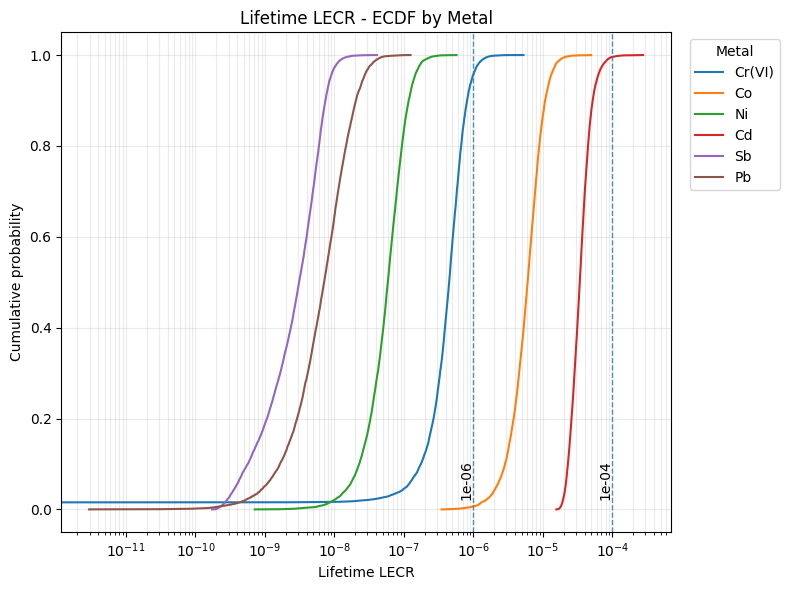

In [7]:
# 금속별 Lifetime LECR 누적확률분포(ECDF) 그리기
# 전제: C_sims, Kg, IUR, ORDER 변수가 이미 존재하고 앞의 코드 그대로 사용

import numpy as np
import matplotlib.pyplot as plt

def ecdf(arr):
    x = np.sort(arr)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

# 금속별 Lifetime LECR 벡터 만들기
lecr_lifetime = {}
for m in ORDER:
    if (m in IUR) and (m in C_sims):
        lecr_lifetime[m] = C_sims[m] * Kg['Lifetime'] * IUR[m]

# 금속별을 한 그래프에 겹쳐서 그리기
plt.figure(figsize=(8,6))

plotted = []
for m, v in lecr_lifetime.items():
    x, y = ecdf(v)
    plt.plot(x, y, label=m)
    plotted.append(m)

# 기준선 (10^-6, 10^-4)
for ref in [1e-6, 1e-4]:
    plt.axvline(ref, linestyle='--', linewidth=1, alpha=0.8)
    plt.text(ref, 0.02, f"{ref:.0e}", rotation=90, va='bottom', ha='right')

plt.xscale('log')
plt.xlabel('Lifetime LECR')
plt.ylabel('Cumulative probability')
plt.title('Lifetime LECR - ECDF by Metal')
plt.grid(True, which='both', axis='both', alpha=0.25)
plt.legend(title='Metal', loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()